In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import re

import sys
sys.path.append("./src/") 

import mnist_data
import plot_utils
import gzip
import importlib

import vae as ve
import matplotlib.pyplot as plt



In [2]:
train_total_data, train_size, _, _, test_data, test_labels = mnist_data.prepare_MNIST_data()
n_samples = train_size

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### train network

encoder_dense_layers [500, 500, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [500, 500, 784]
tanh
elu
decoder output y:(?, 784)
tanh
elu


<IPython.core.display.Javascript object>


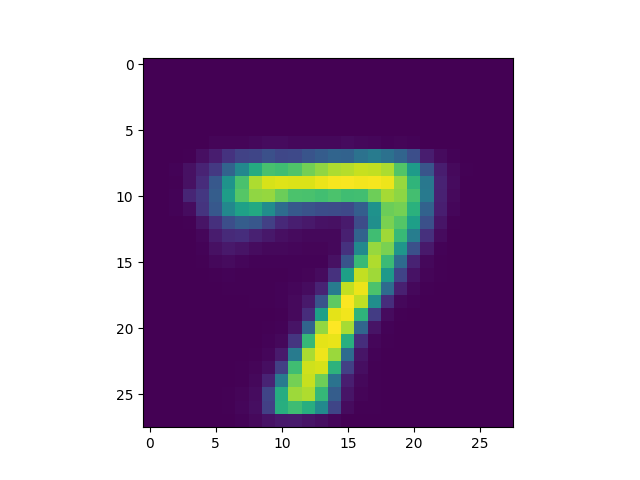

epoch 0: L_tot 207.90 L_likelihood 198.65 L_divergence 9.25
epoch 1: L_tot 196.16 L_likelihood 192.07 L_divergence 4.10
epoch 2: L_tot 193.49 L_likelihood 189.30 L_divergence 4.19
epoch 3: L_tot 183.29 L_likelihood 179.28 L_divergence 4.01
epoch 4: L_tot 185.96 L_likelihood 181.58 L_divergence 4.39
epoch 5: L_tot 170.05 L_likelihood 166.03 L_divergence 4.02
epoch 6: L_tot 173.61 L_likelihood 168.77 L_divergence 4.84
epoch 7: L_tot 180.51 L_likelihood 175.81 L_divergence 4.70
epoch 8: L_tot 177.91 L_likelihood 173.08 L_divergence 4.83
epoch 9: L_tot 168.21 L_likelihood 163.31 L_divergence 4.90
epoch 10: L_tot 176.24 L_likelihood 171.17 L_divergence 5.07
epoch 11: L_tot 181.50 L_likelihood 177.12 L_divergence 4.38
epoch 12: L_tot 173.49 L_likelihood 168.77 L_divergence 4.71
epoch 13: L_tot 173.41 L_likelihood 168.72 L_divergence 4.69
epoch 14: L_tot 164.06 L_likelihood 159.17 L_divergence 4.89
epoch 15: L_tot 173.66 L_likelihood 168.87 L_divergence 4.78
epoch 16: L_tot 167.87 L_likelihoo

In [3]:
%matplotlib notebook 

importlib.reload(ve)

tf.reset_default_graph() 

with tf.Session() as sess:
        
    learning_rate= 1e-3
    dense_layers = [500,500]
    dense_funcs = ['elu','tanh']
    dim_z = 2#20 # latent vector size
    dim_out = 784#new_df_train.shape[1]
    
    
    autoencoder = ve.vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    sess.run(tf.global_variables_initializer(), feed_dict={autoencoder.keep_prob : 0.9})
    
    # train
    n_epochs = 20
    batch_size = 128
#     n_samples = new_df_train.shape[0]#np_train.shape[0]
    total_batch = int(n_samples / batch_size)
    ADD_NOISE = True
#     train_total_data = new_df_train#np_train
    
#     print("total_batch {}".format(total_batch))
    
    for epoch in range(n_epochs):

        # Random shuffling
        np.random.shuffle(train_total_data)
#         train_data_ = train_total_data
        train_data_ = train_total_data[:, :-mnist_data.NUM_LABELS] # (n_samples,784)
        
        # Loop over all batches
        for i in range(total_batch):
            # Compute the offset of the current minibatch in the data.
            offset = (i * batch_size) % (n_samples)
            batch_xs_input = train_data_[offset:(offset + batch_size), :]
#             print("batch_xs_input {}".format(batch_xs_input.shape))
            batch_xs_target = batch_xs_input
            
            
            # add salt & pepper noise
            if ADD_NOISE:
                batch_xs_input = batch_xs_input * np.random.randint(2, size=batch_xs_input.shape)
                batch_xs_input += np.random.randint(2, size=batch_xs_input.shape)
            
            _, tot_loss, loss_likelihood, loss_divergence = sess.run(
                (autoencoder.train_op, autoencoder.loss, autoencoder.neg_marginal_likelihood, autoencoder.KL_divergence),
                feed_dict={autoencoder.x_hat: batch_xs_input, autoencoder.x: batch_xs_target, autoencoder.keep_prob : 0.9})
            
        x_PRR = test_data[0:10, :]
        y_PRR = sess.run(autoencoder.y, feed_dict={autoencoder.x_hat: x_PRR, autoencoder.keep_prob : 1})
        y_PRR_img = y_PRR.reshape(10,28,28)
        plt.imshow(y_PRR_img[0])
        plt.savefig("./" + str(epoch)+'.png')
        
#         print("epoch {}".format(epoch))
        # print cost every epoch
        print("epoch %d: L_tot %03.2f L_likelihood %03.2f L_divergence %03.2f" % (epoch, tot_loss, loss_likelihood, loss_divergence))
        
        
    autoencoder.save(1)

encoder_dense_layers [500, 500, 2]
elu
tanh
gaussian encoder mean:(?, 2) 
mu:(?, 2) sigma:(?, 2)
encoder output z:(?, 2)
decoder_dense_layers [500, 500, 784]
tanh
elu
decoder output y:(?, 784)
tanh
elu
INFO:tensorflow:Restoring parameters from ./model/vae.model-1
 [*] Success to read vae.model-1


<IPython.core.display.Javascript object>


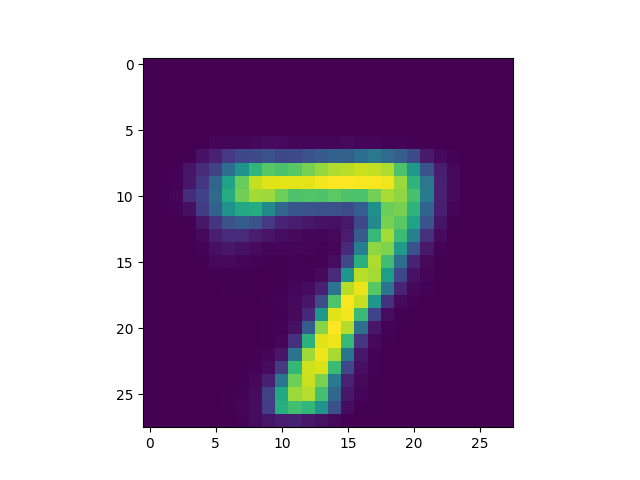

In [6]:
%matplotlib notebook 

tf.reset_default_graph()
with tf.Session() as sess:
    
    learning_rate= 1e-3
    dense_layers = [500,500]
    dense_funcs = ['elu','tanh']
#     dense_funcs = ['tanh','elu']
    dim_z = 2#20 # latent vector size
    dim_out = 784#new_df_train.shape[1]
    
    autoencoder = ve.vae(sess,learning_rate,dense_layers,dense_funcs,dim_z,dim_out)
    autoencoder.load()
    
    
    x_PRR = test_data[0:10, :]
    x_PRR_img = x_PRR.reshape(10, 28,28)

    x_PRR = x_PRR * np.random.randint(2, size=x_PRR.shape)
    x_PRR += np.random.randint(2, size=x_PRR.shape)

    
    y_PRR = sess.run(autoencoder.y, feed_dict={autoencoder.x_hat: x_PRR, autoencoder.keep_prob : 1})
    y_PRR_img = y_PRR.reshape(10,28,28)
    x_PRR_img = x_PRR.reshape(10,28,28)
    plt.imshow(y_PRR_img[0])